In [1]:
# Misc imports
import sys
sys.path.append('/storage/vbutoi/projects')
sys.path.append('/storage/vbutoi/libraries')
sys.path.append('/storage/vbutoi/projects/ESE')
sys.path.append('/storage/vbutoi/projects/UniverSeg')
import torch
torch.set_printoptions(linewidth=200)
import seaborn as sns
sns.set_style("darkgrid")
import os 
os.environ['DATAPATH'] = ':'.join((
       '/storage/vbutoi/datasets',
       '/storage'
))
import yaml
from pathlib import Path
# Local imports
from ese.experiment.analysis.run_inference import get_cal_stats
from ese.experiment.analysis.analysis_utils.submit_utils import get_ese_inference_configs
# Ionpy imports
from ionpy.util import Config
from ionpy.analysis import ResultsLoader

# Define some useful paths.
scratch_root = Path("/storage/vbutoi/scratch/ESE")
code_root = Path("/storage/vbutoi/projects/ESE")
rs = ResultsLoader()

# For using code without restarting.
%load_ext autoreload
%autoreload 2
# For using yaml configs.
%load_ext yamlmagic

/storage/vbutoi/projects/ionpy/pandas/register.py:47: UserWarning: registration of accessor <class 'ionpy.pandas.register.register_series_method.<locals>.inner.<locals>.AccessorMethod'> under name 'fillNA' for type <class 'pandas.core.series.Series'> is overriding a preexisting attribute with the same name.
  register_series_accessor(method.__name__)(AccessorMethod)
/storage/vbutoi/projects/ionpy/pandas/register.py:47: UserWarning: registration of accessor <class 'ionpy.pandas.register.register_series_method.<locals>.inner.<locals>.AccessorMethod'> under name 'isNA' for type <class 'pandas.core.series.Series'> is overriding a preexisting attribute with the same name.
  register_series_accessor(method.__name__)(AccessorMethod)
/storage/vbutoi/projects/ionpy/pandas/register.py:47: UserWarning: registration of accessor <class 'ionpy.pandas.register.register_series_method.<locals>.inner.<locals>.AccessorMethod'> under name 'notNA' for type <class 'pandas.core.series.Series'> is overriding 

In [2]:
%%yaml inference_config

experiment:
    exp_root: '?'
    supports_per_target: '?' 
    seed: 40
    threshold: 0.5 
    fixed_support_sets: True

log:
    root: '?'
    min_fg_pixels: 0 
    log_interval: 20 
    save_preds: False
    log_image_stats: True 
    log_pixel_stats: True 
    gether_inference_stats: True
    track_ensemble_member_scores: False 
    summary_compute_global_metrics: True

dataloader:
    batch_size: 1 
    num_workers: 0
    pin_memory: True 

<IPython.core.display.Javascript object>

In [3]:
%%yaml calibration_cfg 

calibrator:
    _name: '?'
    normalize: False

local_calibration:
    num_prob_bins: 15
    neighborhood_width: 3
    square_diff: False 

global_calibration:
    num_prob_bins: 15
    num_classes: 2
    neighborhood_width: 3
    square_diff: False 
    loss_weights: None 

<IPython.core.display.Javascript object>

In [4]:
%%yaml incontext_model_cfg 

# # For incontext datasets
####################################
data:
    splits: ('val',)
    support_size: 8 
    preload: False 

ensemble:
    combine_fn: 'mean' 
    combine_quantity: 'probs'
    normalize: False

model:
    _type: "incontext"
    pretrained_exp_root : None
    checkpoint: "max-val_od-dice_score"

<IPython.core.display.Javascript object>

In [5]:
exp_name = f'05_28_24_MM_Pairwise'
group_dict = {
    "datasets": [
        # "ACDC",
        # "PanDental_Jaw",
        # "PanDental_Mandible",
        "SpineWeb", 
        # "STARE",
        # "WBC"
    ],
    "exp_group": exp_name,
    "model_type": "incontext",
    "base_models_group": "/storage/jjgo/results/omni/2023-02-16_Universeg-HO_Adrian/20230214_112221-1C7K-2cb972b55f72d56b3842c2d2d8bdd3c6",
    "scratch_root": "/storage/vbutoi/scratch/ESE",
    "inf_cfg_root": "/storage/vbutoi/projects/ESE/ese/experiment/configs/inference",
}

## Gather Inference Options.

In [6]:
%%yaml inference_config_opts

experiment.supports_per_target:
    - 100 

<IPython.core.display.Javascript object>

In [7]:
# Load the inference cfg from local.
##################################################
inf_cfg_root = code_root / "ese" / "experiment" / "configs" / "inference"

##################################################
with open(inf_cfg_root / "Calibration_Metrics.yaml", 'r') as file:
    cal_metrics_cfg = yaml.safe_load(file)

##################################################
base_cfg = Config(inference_config).update([calibration_cfg, cal_metrics_cfg, incontext_model_cfg])

In [8]:
# Get the configs for the different runs.
inf_cfgs = get_ese_inference_configs(
    group_dict=group_dict,
    base_cfg=base_cfg,
    inf_cfg_opts=inference_config_opts,
    power_set_keys=['experiment.support_augs']
)

WARNING! Calibrator not found, using default calibrator name: Uncalibrated.


In [9]:
len(inf_cfgs)

1

## Running Jobs

In [10]:
from ese.experiment.analysis.run_inference import get_cal_stats

/storage/vbutoi/libraries/pylot/util/libcheck.py:49: UserWarning: Intel MKL extensions not available for NumPy
  warn("Intel MKL extensions not available for NumPy")
/storage/vbutoi/libraries/pylot/util/libcheck.py:57: UserWarning: Using slow Pillow instead of Pillow-SIMD
  warn("Using slow Pillow instead of Pillow-SIMD")


Set seed: 40
None
Running:

calibrator:
  _class: Uncalibrated
  _name: Uncalibrated
  normalize: false
data:
  input_type: image
  labels: &id001
  - 0
  preload: false
  resolution: 128
  slicing: midslice
  splits: ('val',)
  support_size: 8
  task: SpineWeb/Dataset7/MR/0
dataloader:
  batch_size: 1
  num_workers: 0
  pin_memory: true
dataset:
  _class: universeg.experiment.datasets.MultiBinarySegment2D
  augmentations: null
  labels: *id001
  min_label_density: 3e-3
  preload: false
  resolution: 128
  return_data_id: true
  samples_per_epoch: 1000
  slicing: midslice
  support_size: 8
  task: SpineWeb/Dataset7/MR/0
  version: v4.2
ensemble:
  combine_fn: mean
  combine_quantity: probs
  normalize: false
  num_members: 1
experiment:
  dataset_name: SpineWeb
  exp_name: 05_28_24_MM_Pairwise
  exp_root: /storage/vbutoi/scratch/ESE/inference/05_28_24_MM_Pairwise
  fixed_support_sets: true
  pretrained_seed: 42
  seed: 40
  supports_per_target: 100
  threshold: 0.5
global_cal_metrics:


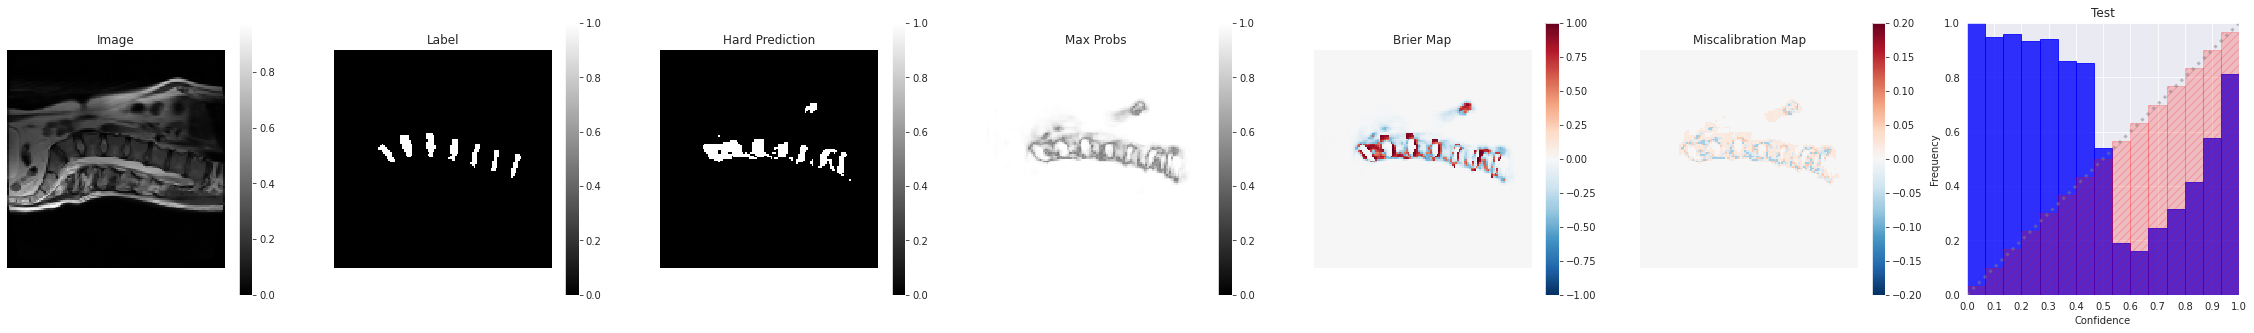

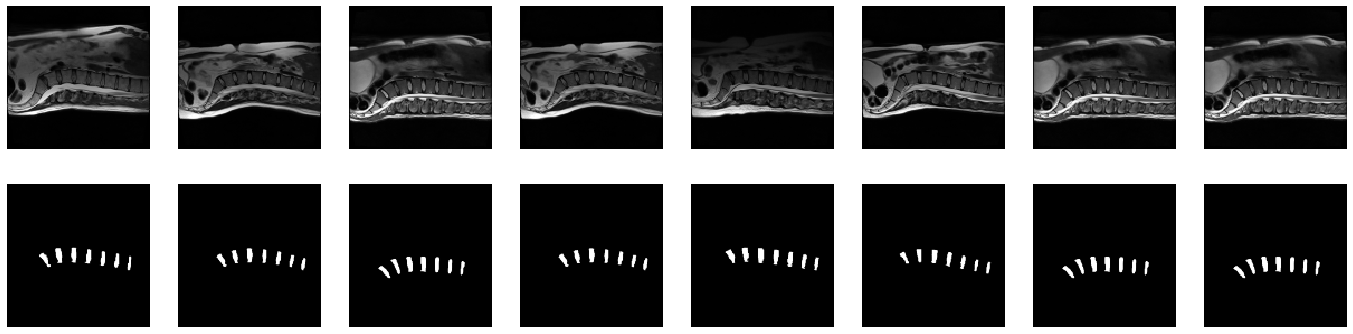

Dice: 0.5622857213020325
HD95: 5.0
BoundaryIOU: 0.39109697937965393
Accuracy: 0.97662353515625
SoftVolumeError: 356.918701171875
HardVolumeError: 209.0
Image_ECE: 0.0026665482073439666
Image_Edge-ECE: 0.16549653430347858
Image_CW-ECE: 0.0217845868319273
Image_ECW-ECE: 0.027942944318056107
Image_Uniform-CW-ECE: 0.0217845868319273
Image_Uniform-ECW-ECE: 0.0901515781879425


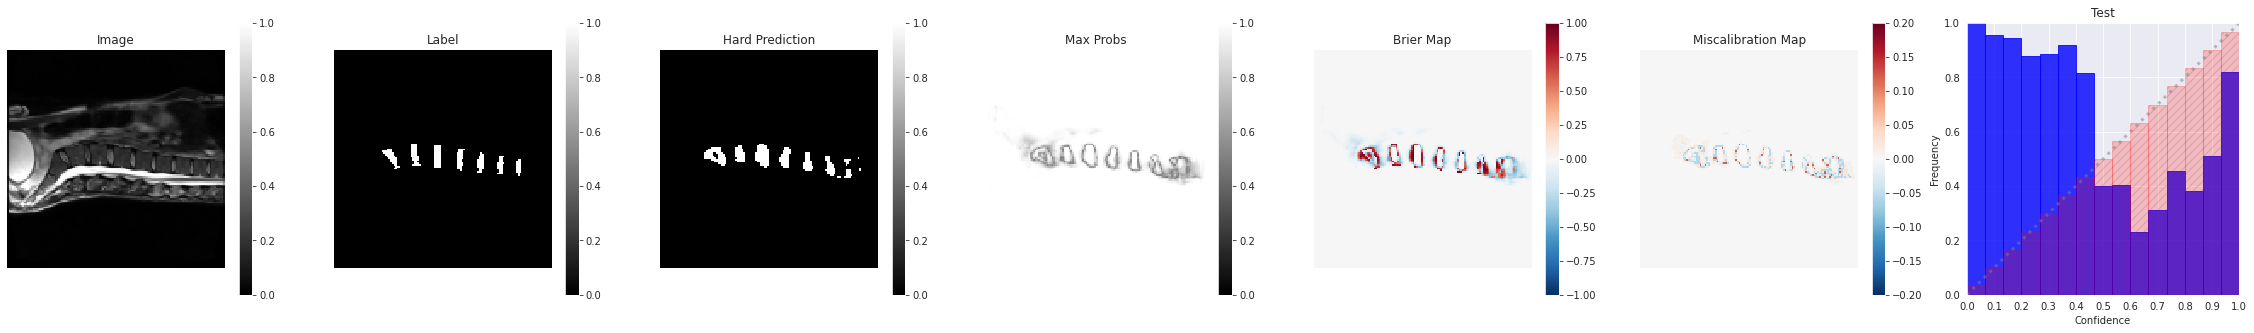

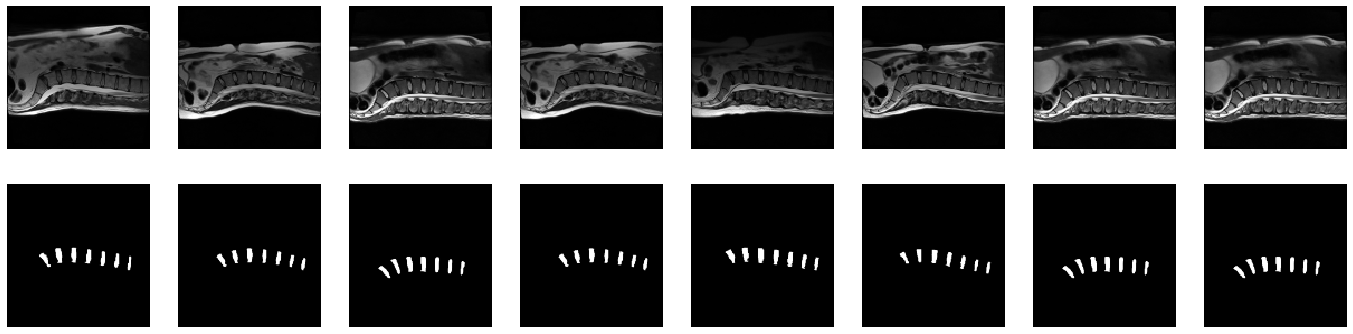

Dice: 0.6280752420425415
HD95: 3.0
BoundaryIOU: 0.45780590176582336
Accuracy: 0.98431396484375
SoftVolumeError: 223.12890625
HardVolumeError: 119.0
Image_ECE: 0.002120967234077455
Image_Edge-ECE: 0.16289561031798078
Image_CW-ECE: 0.013618707656860352
Image_ECW-ECE: 0.019519787281751633
Image_Uniform-CW-ECE: 0.013618707656860352
Image_Uniform-ECW-ECE: 0.09043577313423157


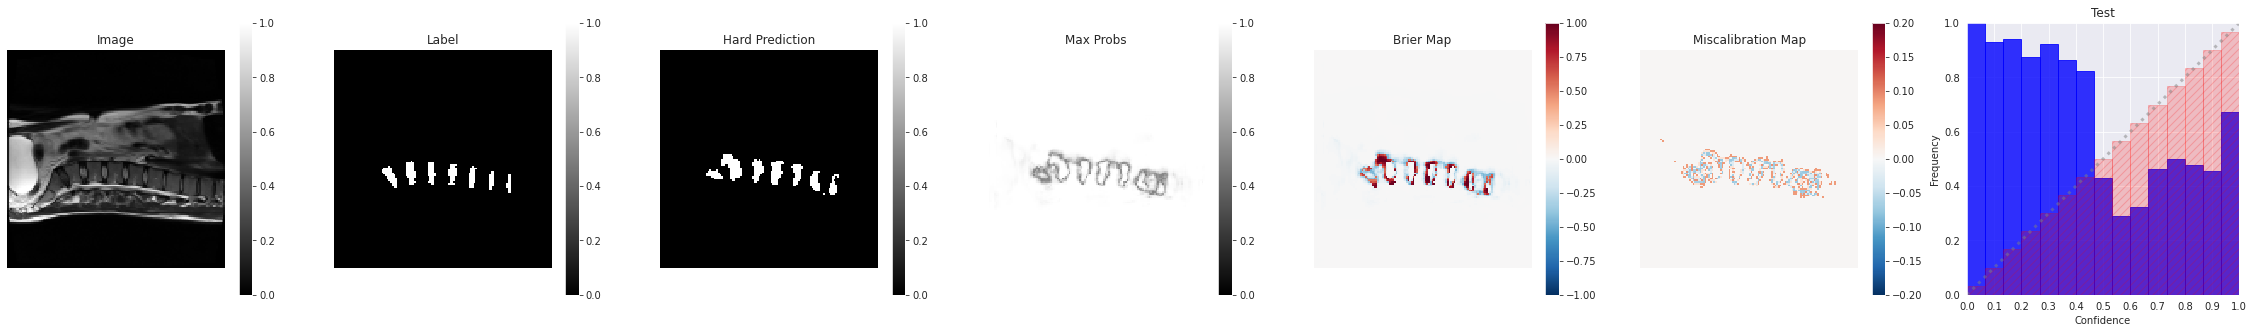

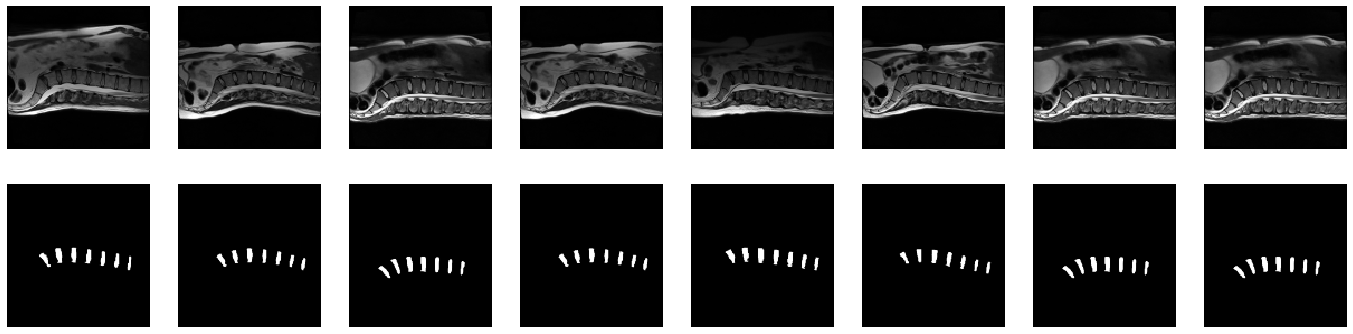

Dice: 0.6145695447921753
HD95: 3.2730960845947266
BoundaryIOU: 0.44359463453292847
Accuracy: 0.98223876953125
SoftVolumeError: 226.2435302734375
HardVolumeError: 129.0
Image_ECE: 0.005045329518907262
Image_Edge-ECE: 0.1883710866678737
Image_CW-ECE: 0.01400594599545002
Image_ECW-ECE: 0.02062266506254673
Image_Uniform-CW-ECE: 0.01400594599545002
Image_Uniform-ECW-ECE: 0.09590291231870651


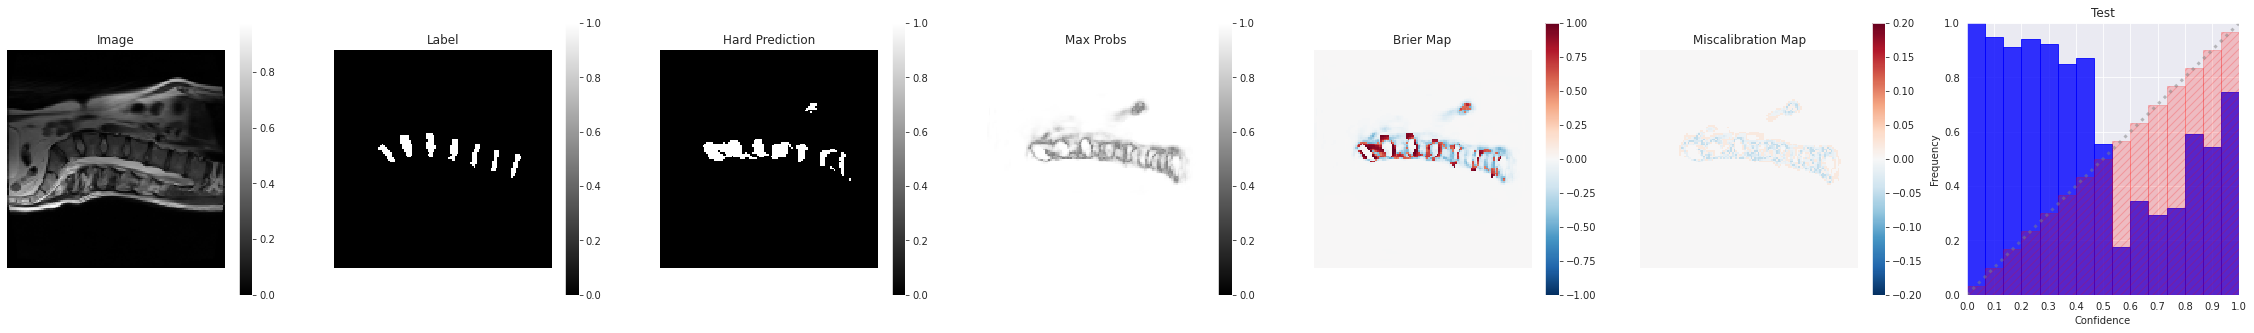

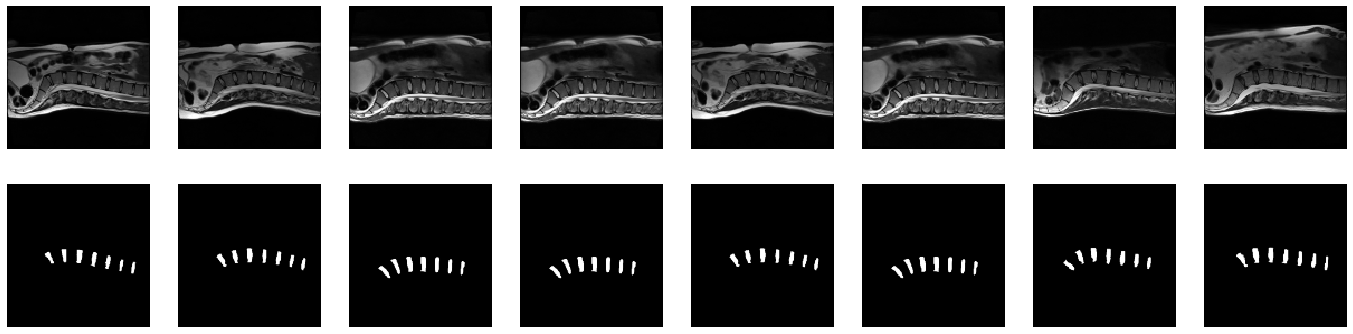

Dice: 0.5693950057029724
HD95: 5.0
BoundaryIOU: 0.3980099558830261
Accuracy: 0.97784423828125
SoftVolumeError: 319.462158203125
HardVolumeError: 177.0
Image_ECE: 0.002657944292877805
Image_Edge-ECE: 0.18237941312617148
Image_CW-ECE: 0.019498422741889954
Image_ECW-ECE: 0.026108236983418465
Image_Uniform-CW-ECE: 0.019498422741889954
Image_Uniform-ECW-ECE: 0.0922265350818634


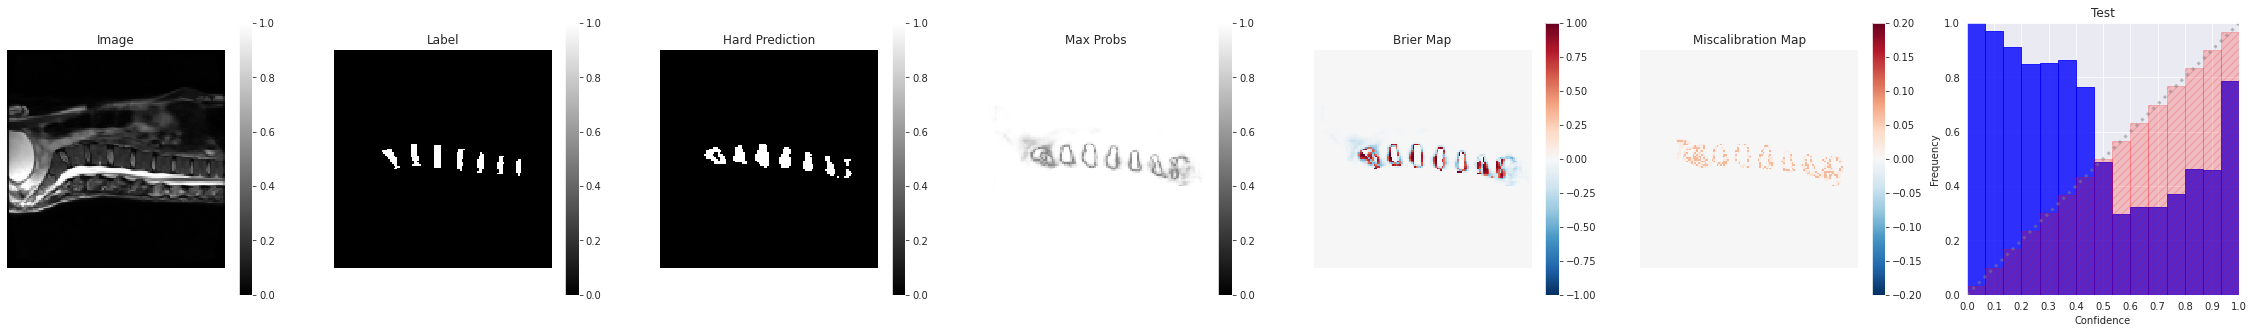

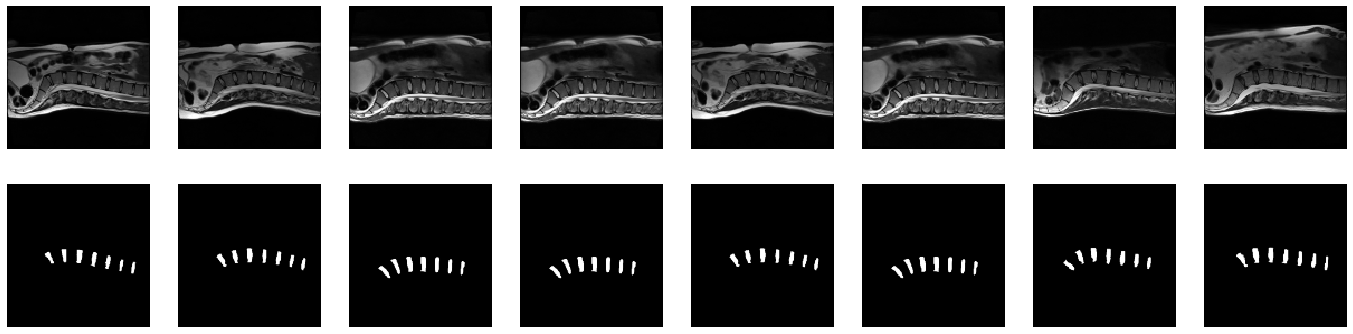

Dice: 0.6298984289169312
HD95: 2.8284270763397217
BoundaryIOU: 0.45974576473236084
Accuracy: 0.98443603515625
SoftVolumeError: 195.71060180664062
HardVolumeError: 117.0
Image_ECE: 0.002159459039830768
Image_Edge-ECE: 0.18496652778698994
Image_CW-ECE: 0.011945226229727268
Image_ECW-ECE: 0.01820015162229538
Image_Uniform-CW-ECE: 0.011945226229727268
Image_Uniform-ECW-ECE: 0.09459512680768967


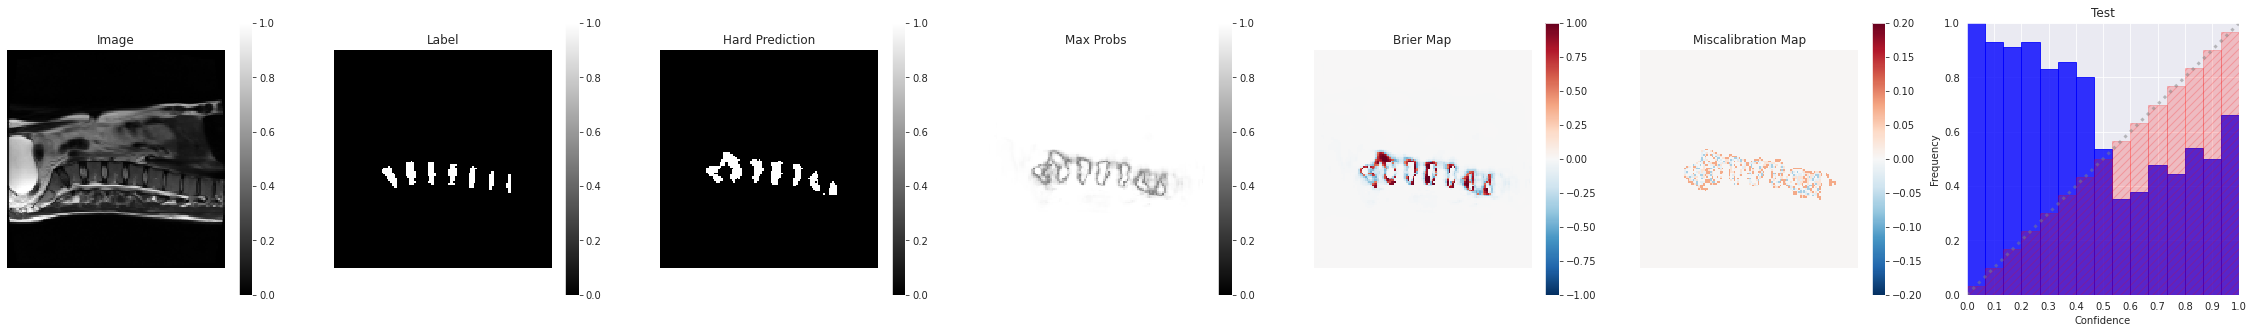

KeyboardInterrupt: 

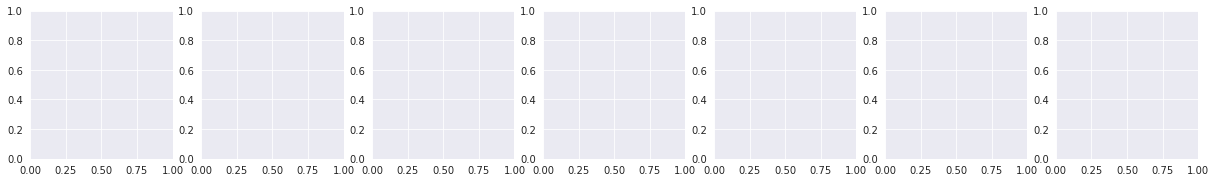

In [11]:
from ese.experiment.experiment import run_ese_exp

###### Run individual jobs
run_ese_exp(
    config=inf_cfgs[0], 
    job_func=get_cal_stats,
    run_name='debug',
    show_examples=True,
    gpu='0',
) 

In [ ]:
# from ese.experiment.experiment import submit_ese_exps 

# #### Run Batch Jobs
# submit_ese_exps(
#     config_list=inf_cfgs,
#     job_func=get_cal_stats,
#     available_gpus=[
#         # '0', 
#         '1', 
#         '2', 
#         '3'
#     ]
# )